I've taken help from <a href="https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9"> blog on MLP </a>

In [1]:
# importing libraries
import numpy as np
import typing as ty
import torchvision
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# setting seed
np.random.seed(0)

def dataloader():
    train_ = torchvision.datasets.MNIST("files/")

    train_dict = { i:[] for i in range(10) }

    for image, label in train_:
        train_dict[label].append(np.array(image).reshape(28,28,1)/1.)

    # 1K images, 100 for each label
    train = []
    label = []
    for i in range(10):
        label.extend([i]*100)
        train.extend(train_dict[i][100:200])
    y_train = np.array(label)
    X_train = np.array(train)

    # validation set
    train = []
    label = []
    for i in range(10):
        label.extend([i]*10)
        train.extend(train_dict[i][400:410])
    y_val = np.array(label)
    X_val = np.array(train)

    return X_train, y_train, X_val, y_val
    
const = 0.02
X_train, y_train, X_val, y_val = dataloader()

/home/cmaspi/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


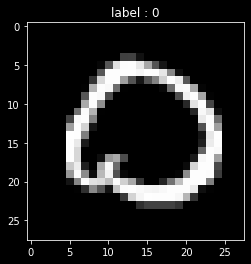

In [2]:
plt.imshow(X_train[0], cmap = 'gray')
plt.title(f'label : {y_train[0]}')
plt.show()

In [3]:
# cross entropy loss

def cross_entropy(p: np.ndarray, q:np.ndarray) -> float:
    """This function returns the cross entropy betwen the two given pmfs
    
    The formula used is : - sum p log q
    """
    return -np.mean(np.log(q[np.arange(p.shape[0]),p]))

# cross_entropy_util = lambda 


# activation functions
def relu(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """ReLU function
    
    returns max(0,x)"""
    return np.maximum(0,x)

def softmax(x : np.ndarray) -> np.ndarray:
    """Softmax function
    
    return [e^x_i/sum(e^x_i) for all i]"""
    denom = np.sum(np.exp(x), axis=-1)
    return np.exp(x)/denom[:,None]

# max pooling
max_pool = lambda x: np.max(x)

In [4]:
class Layer:
    def __init__(self) -> None:
        pass

    def forward(self, input : np.ndarray) -> np.ndarray:
        return input
    
    def backprop(self, input : np.ndarray, grad_in):
        pass

In [5]:
class conv2D(Layer):
    def __init__(self, num_kernels, kernel_shape, learning_rate : int = 0.001, momentum = False, eta = 0.9, rmsprop = False, rho = 0.9) -> None:
        self.num_kernels = num_kernels
        self.kernel_shape = kernel_shape
        self.learning_rate = learning_rate
        self.prev_change = [np.zeros(kernel_shape) for _ in range(self.num_kernels)]
        self.kernels = []
        self.padding = 2
        self.rmsprop = rmsprop
        self.rho = rho
        
        for _ in range(self.num_kernels):
            k = np.random.normal(0, np.sqrt(2/np.product(kernel_shape)), kernel_shape)
            self.kernels.append(k)
        self.momentum = momentum
        self.eta = eta
        self.epsilon = 1e-9

    def forward(self, input : np.ndarray):
        padding = self.padding
        output = []
        for img in input:
            k = self.kernel_shape[0]

            horizontal_flipped = img[::-1]
            vertical_flipped = img[:,::-1]
            fully_flipped = img[::-1,::-1]
            W,H,c = img.shape
            padded_array = np.zeros((W+2*padding, H+2*padding,c))
            padded_array[padding:-padding,padding:-padding] = img.copy()
            padded_array[:padding,:padding] = fully_flipped[-padding:,-padding:]
            padded_array[-padding:,-padding:] = fully_flipped[:padding,:padding]
            padded_array[:padding,-padding:] = fully_flipped[-padding:,:padding]
            padded_array[-padding:,:padding] = fully_flipped[:padding,-padding:]
            padded_array[:padding,padding:-padding] = horizontal_flipped[-padding:,:]
            padded_array[-padding:,padding:-padding] = horizontal_flipped[:padding,:]
            padded_array[padding:-padding,:padding] = vertical_flipped[:,-padding:]
            padded_array[padding:-padding,-padding:] = vertical_flipped[:,:padding]

            out = []
            for kernel in self.kernels:
                x,y = 0, 0
                temp = np.zeros(img.shape[:2])
                # print(temp.shape)
                for i in range(W+1+2*padding-k,):
                    for j in range(H+1+2*padding-k):
                        temp[x, y] = np.sum(padded_array[i:i+k,j:j+k,:]*kernel)
                        y+=1
                    x+=1
                    y=0
                out.append(temp)                
            out = np.dstack(out)        
            output.append(out)
        output = np.array(output)
        return output

    def backprop(self, input : np.ndarray, grad_out):
        """
        What is being done
        ------------------
        Say we have 14 x 14 x 4 image and 4 (5 x 5 x 4) kernels
        We take the grad_out which is 14 x 14 x 4 array and multiply it with
        each kernel to make 18 x 18 x 4 array for each kernel,
        We will further take only the central portion
        or just fold the array on edges

        to update the kernels, we will use the fact that
        dL/dK = dL/dO * I 

        so basically, we have dL/dO as grad_out
        the dimensions are N x 14 x 14 x 4
        while for input, we have dimensions N x 14 x 14 x 4
        so for kernel 1
        dL/dk1 =    I      {conv}      dL/dO
                N x 18 x 18 x 4 ||| N x 14 x 14 x 4
                              ^                   ^
                       number of channels | number of kernels

        Notice that I is the padded image,
        we will take convolution of each channel in input with each output corresponding to the kernel.
        so we will convolute
        18 x 18 with 14 x 14, then for each channel when we do this and stack them
        we will get 5 x 5 x 4, this is for one kernel, we will do this for all 4 kernels

        ----------------
        For the cases of 28 x 28 x 1, and 4 kernels 5 x 5 x 1
        we take the grad_out which is 28 x 28 x 4, and multiply it with each kernel
        """
        padding = self.padding
        
        N, W, H, _ = input.shape
        C = self.kernels.__len__()
        grad_in_overall = []
        for i in range(N):
            grad_in = np.zeros_like(input[i])
            for c in range(C):
                dxk = np.zeros((W+2*padding, H+2*padding, input[0].shape[-1]))
                for xx in range(W):
                    for yy in range(H):
                        dxk[xx:xx+2*padding+1,yy:yy+2*padding+1,:] += grad_out[i, xx,yy, c] * self.kernels[c]
                grad_in += dxk[padding:-padding,padding:-padding,:]
            grad_in_overall.append(grad_in)
        N, W, H, C = input.shape
        num = grad_out.shape[-1] # number of kernels

        dk = [np.zeros(self.kernel_shape) for i in range(num)]

        for i in range(N):
            img = input[i]
            K = self.kernel_shape[0]
            horizontal_flipped = img[::-1]
            vertical_flipped = img[:,::-1]
            fully_flipped = img[::-1,::-1]
            W,H,c = img.shape
            padded_array = np.zeros((W+2*padding, H+2*padding,c))
            padded_array[padding:-padding,padding:-padding] = img.copy()
            padded_array[:padding,:padding] = fully_flipped[-padding:,-padding:]
            padded_array[-padding:,-padding:] = fully_flipped[:padding,:padding]
            padded_array[:padding,-padding:] = fully_flipped[-padding:,:padding]
            padded_array[-padding:,:padding] = fully_flipped[:padding,-padding:]
            padded_array[:padding,padding:-padding] = horizontal_flipped[-padding:,:]
            padded_array[-padding:,padding:-padding] = horizontal_flipped[:padding,:]
            padded_array[padding:-padding,:padding] = vertical_flipped[:,-padding:]
            padded_array[padding:-padding,-padding:] = vertical_flipped[:,:padding]
            # padded_array is 18 x 18 x 4
            for k in range(num): # this is the index of kernel
                for c in range(C): # this is index of channels
                    # remember that we will take convolution of this single channel matrix
                    # with our grad_output for different kernels
                    for xx in range(2*padding+1):
                        for yy in range(2*padding+1):
                            dk[k][xx,yy,c] += np.sum(padded_array[xx:xx+W, yy:yy+H,c]*grad_out[i,:,:,k])*5
        for k in range(num):
            if not self.rmsprop:
                self.kernels[k] -= dk[k]*self.learning_rate
            else:
                self.prev_change[k] = self.rho*self.prev_change[k] + (1-self.rho) * dk[k]**2
                self.kernels[k] -= self.learning_rate * dk[k]/(np.sqrt(self.prev_change[k])+self.epsilon)
        if self.momentum:
            for k in range(num):
                self.kernels[k] -= self.eta * self.prev_change[k]
                self.prev_change[k] = dk[k] * self.learning_rate
        return np.array(grad_in_overall, dtype = object)


In [6]:
l = conv2D(4,(5,5,4))
x = np.random.randn(28,28,4)
y = np.random.randn(28,28,4)
a= l.forward(np.array([x,y]))
l.backprop(np.array([x,y]), np.array([y,x])).shape

(2, 28, 28, 4)

In [7]:
class max_pooling3D(Layer):
    def __init__(self, stride : ty.Tuple[int, int], size : ty.Tuple[int,int]):
        """Initialising the stride"""
        self.stride = stride
    
    def forward(self, input : np.ndarray):
        """Forward pass for 3D max pooling layer"""
        N, rows, columns, channels = input.shape
        out = input.reshape(N,rows//self.stride[0], self.stride[0], columns//self.stride[1], self.stride[1], channels).max(axis=(2,4))
        return out
    def backprop(self, input : np.ndarray, grad_out):
        """
        Taken grad input from next layer, it will make the grad 0 where ever
        the input in window is not maximum
        example
        grad_out is N x 7 x 7 x 4
        this should be made into N x 14 x 14 x 4
        We will achieve this by assigning this gradient to arg max indices
        """
        N, rows, columns, channels = input.shape
        grad_in = np.zeros_like(input)
        for n in range(N):
            for i in range(rows//self.stride[0]):
                for j in range(columns//self.stride[1]):
                    for c in range(channels):
                        window = input[i,2*i:2*i+2, 2*j : 2*j+2, c]
                        d = np.unravel_index(window.argmax(), window.shape)
                        grad_in[n,2*i+d[0],2*j+d[1],c] = grad_out[n,i,j,c]
        return grad_in


In [8]:
class flatten(Layer):
    def __init__(self, dim_in:ty.Tuple[int,int,int]) -> None:
        self.dim_in = dim_in

    def forward(self,  input : np.ndarray):
        """forward pass flatten
        The input image will be N x 7 x 7 x 4"""
        N = input.shape[0]
        # since the flattening layer will flatten the
        # 7 x 7 x 4 to 196
        return input.reshape(N, np.product(self.dim_in))
    
    def backprop(self, input : np.ndarray, grad_out):
        """
        Backprop in this flattening layer is basically
        reshaping the gradient, here grad_out is N x 196
        matrix, we will reshape it to N x 7 x 7 x 4
        """
        return grad_out.reshape(input.shape)    
        

In [9]:
class ReLU(Layer):
    def __init__(self) -> None:
        pass

    def forward(self, input : np.ndarray):
        """forward pass relu function"""
        return relu(input)
    
    def backprop(self, input, grad_out):
        # ReLU gradient is 0 when input is negative, 1 otherwise
        return grad_out * (input > 0)

In [10]:
class Dense(Layer):
    def __init__(self, dimensions, learning_rate=0.001, momentum = False, eta = 0.9, rmsprop = False, rho = 0.9):
        """
        This function returns x.T W + b\\
        where W is the weight matrix,\\
        b is the bias vector\\
        These variables are defined for the class
        """
        self.learning_rate = learning_rate
        self.momentum = momentum
        # *dimensions : * unpacks the tuple
        self.weights = np.random.normal(0, np.sqrt(2/np.product(dimensions)), dimensions) 
        self.bias = np.zeros(dimensions[1])
        self.W_prev_grad = np.zeros(dimensions)
        self.b_prev_grad = np.zeros(dimensions[1])
        self.eta = eta
        self.rmsprop = rmsprop
        self.rho = rho
        self.epsilon = 1e-9

    def forward(self,input):
        """
        This function returns XW + b\\
        where W is the weight matrix,\\
        b is the bias vector\\
        These variables are defined for the class
        """
        return input @ self.weights + self.bias
    
    def backprop(self, input, grad_out):
        """
        We are given the gradient computed till this layer, we have
        to backpropagate it from this layer.\\
        This will be \\
        grad_out = dL/d(XW + b) \\
        further, \\
        dL/dx = dL/d(XW+b) d(XW+b)/dx \\
        dL/dx = grad_out * W.T
        """
        # gradient to be passed to previous layer
        grad_in = grad_out @ self.weights.T
        
        # compute gradient w.r.t. weights and bias
        # input.T       dim_in x N
        # grad_out   N x dim_out
        grad_weights = input.T @ grad_out
        # we are taking sum along the dimensions to bring down the dimensionality from 2D to a vector
        # essentially, we are adding the different gradients together.
        grad_bias = grad_out.sum(axis=0)
        
        # grad_weights is sum of gradients over the batch
        # so is grad_bias, it is also the sum of gradients over the batch.
        if not self.rmsprop:
            self.weights = self.weights - self.learning_rate * grad_weights
            self.biases = self.bias - self.learning_rate * grad_bias
        if self.rmsprop:
            self.W_prev_grad = self.rho * self.W_prev_grad + (1-self.rho)*grad_weights**2
            self.b_prev_grad = self.rho * self.b_prev_grad + (1-self.rho)*grad_bias**2
            self.weights -= self.learning_rate * grad_weights/(np.sqrt(self.W_prev_grad)+self.epsilon)
            self.bias -= self.learning_rate * grad_bias/(np.sqrt(self.b_prev_grad)+self.epsilon)
            

        if self.momentum:
            self.weights -= self.eta * self.W_prev_grad
            self.W_prev_grad = self.learning_rate* grad_weights
            self.bias -= self.eta * self.b_prev_grad
            self.b_prev_grad = self.learning_rate * grad_bias

        # returning the gradient for the previous layer
        return grad_in

In [11]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))    
    return xentropy
    
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [12]:
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    return activations
    
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

__predict__ = lambda network,X : softmax(forward(network,X)[-1])


def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backprop(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Vanilla SGD , batch size = 15

In [13]:
network = []
network.append(conv2D(4,(5,5,1), momentum=False))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(conv2D(4,(5,5,4), momentum = False))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(flatten((7,7,4)))
network.append(Dense((196,49), momentum = False))
network.append(ReLU())
network.append(Dense((49,10), momentum=False))

from sklearn.manifold import TSNE
        
train_log = []
val_log = []
train_accuracy_log = []
val_accuracy_log = []
for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=15,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_accuracy_log.append(np.mean(predict(network,X_train)==y_train))
    val_accuracy_log.append(np.mean(predict(network,X_val)==y_val))
    train_log.append(np.mean(cross_entropy(y_train, __predict__(network,X_train))))
    val_log.append(np.mean(cross_entropy(y_val, __predict__(network,X_val))))
    
    print("Epoch",epoch+1)
    print("Train loss:",train_log[-1])
    print("Test loss:",val_log[-1])
    print("Train accuracy:",train_accuracy_log[-1])
    print("Test accuracy:",val_accuracy_log[-1])
    
    if epoch in [0,14]:
        logits = __predict__(network, X_val)
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits)
        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_val[10*i]}')
        ax.legend()
        plt.show()
    
    single_image = np.array([X_train[0]])
    layer_activation = forward(network, single_image)
    fig,ax = plt.subplots(2,4, figsize=(12,3))
    ax[0][0].imshow(layer_activation[0][:,:,:,0].reshape(28,28), cmap = 'gray')
    ax[0][1].imshow(layer_activation[0][:,:,:,1].reshape(28,28), cmap = 'gray')
    ax[0][2].imshow(layer_activation[0][:,:,:,2].reshape(28,28), cmap = 'gray')
    ax[0][3].imshow(layer_activation[0][:,:,:,3].reshape(28,28), cmap = 'gray')
    ax[1][0].imshow(layer_activation[3][:,:,:,0].reshape(14,14), cmap = 'gray')
    ax[1][1].imshow(layer_activation[3][:,:,:,1].reshape(14,14), cmap = 'gray')
    ax[1][2].imshow(layer_activation[3][:,:,:,2].reshape(14,14), cmap = 'gray')
    ax[1][3].imshow(layer_activation[3][:,:,:,3].reshape(14,14), cmap = 'gray')
    plt.show()

plt.plot(train_log,label='train loss')
plt.plot(val_log,label='test loss')
plt.legend(loc='best')
plt.grid()
plt.show()

100%|██████████| 66/66 [00:44<00:00,  1.48it/s]


KeyboardInterrupt: 

# Momentum , batch size = 15

In [ ]:
network = []
network.append(conv2D(4,(5,5,1), momentum=True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(conv2D(4,(5,5,4), momentum = True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(flatten((7,7,4)))
network.append(Dense((196,49), momentum = True))
network.append(ReLU())
network.append(Dense((49,10), momentum=True))

train_log = []
val_log = []
train_accuracy_log = []
val_accuracy_log = []
for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=15,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_accuracy_log.append(np.mean(predict(network,X_train)==y_train))
    val_accuracy_log.append(np.mean(predict(network,X_val)==y_val))
    train_log.append(np.mean(cross_entropy(y_train, __predict__(network,X_train))))
    val_log.append(np.mean(cross_entropy(y_val, __predict__(network,X_val))))
    
    print("Epoch",epoch+1)
    print("Train loss:",train_log[-1])
    print("Test loss:",val_log[-1])
    print("Train accuracy:",train_accuracy_log[-1])
    print("Test accuracy:",val_accuracy_log[-1])
    
    if epoch in [0,14]:
        logits = __predict__(network, X_val)
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits)
        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_val[10*i]}')
        ax.legend()
        plt.show()

    single_image = np.array([X_train[0]])
    layer_activation = forward(network, single_image)
    fig,ax = plt.subplots(2,4, figsize=(12,3))
    ax[0][0].imshow(layer_activation[0][:,:,:,0].reshape(28,28), cmap = 'gray')
    ax[0][1].imshow(layer_activation[0][:,:,:,1].reshape(28,28), cmap = 'gray')
    ax[0][2].imshow(layer_activation[0][:,:,:,2].reshape(28,28), cmap = 'gray')
    ax[0][3].imshow(layer_activation[0][:,:,:,3].reshape(28,28), cmap = 'gray')
    ax[1][0].imshow(layer_activation[3][:,:,:,0].reshape(14,14), cmap = 'gray')
    ax[1][1].imshow(layer_activation[3][:,:,:,1].reshape(14,14), cmap = 'gray')
    ax[1][2].imshow(layer_activation[3][:,:,:,2].reshape(14,14), cmap = 'gray')
    ax[1][3].imshow(layer_activation[3][:,:,:,3].reshape(14,14), cmap = 'gray')
    plt.show()

    
plt.plot(train_log,label='train loss')
plt.plot(val_log,label='test loss')
plt.legend(loc='best')
plt.grid()
plt.show()

# RMSPROP, batch size = 15

In [ ]:
network = []
network.append(conv2D(4,(5,5,1), rmsprop = True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(conv2D(4,(5,5,4), rmsprop = True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(flatten((7,7,4)))
network.append(Dense((196,49), rmsprop = True))
network.append(ReLU())
network.append(Dense((49,10), rmsprop = True))

        
train_log = []
val_log = []
train_accuracy_log = []
val_accuracy_log = []
for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=15,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_accuracy_log.append(np.mean(predict(network,X_train)==y_train))
    val_accuracy_log.append(np.mean(predict(network,X_val)==y_val))
    train_log.append(np.mean(cross_entropy(y_train, __predict__(network,X_train))))
    val_log.append(np.mean(cross_entropy(y_val, __predict__(network,X_val))))
    
    print("Epoch",epoch+1)
    print("Train loss:",train_log[-1])
    print("Test loss:",val_log[-1])
    print("Train accuracy:",train_accuracy_log[-1])
    print("Test accuracy:",val_accuracy_log[-1])
    
    if epoch in [0,14]:
        logits = __predict__(network, X_val)
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits)
        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_val[10*i]}')
        ax.legend()
        plt.show()
    
    single_image = np.array([X_train[0]])
    layer_activation = forward(network, single_image)
    fig,ax = plt.subplots(2,4, figsize=(12,3))
    ax[0][0].imshow(layer_activation[0][:,:,:,0].reshape(28,28), cmap = 'gray')
    ax[0][1].imshow(layer_activation[0][:,:,:,1].reshape(28,28), cmap = 'gray')
    ax[0][2].imshow(layer_activation[0][:,:,:,2].reshape(28,28), cmap = 'gray')
    ax[0][3].imshow(layer_activation[0][:,:,:,3].reshape(28,28), cmap = 'gray')
    ax[1][0].imshow(layer_activation[3][:,:,:,0].reshape(14,14), cmap = 'gray')
    ax[1][1].imshow(layer_activation[3][:,:,:,1].reshape(14,14), cmap = 'gray')
    ax[1][2].imshow(layer_activation[3][:,:,:,2].reshape(14,14), cmap = 'gray')
    ax[1][3].imshow(layer_activation[3][:,:,:,3].reshape(14,14), cmap = 'gray')
    plt.show()


plt.plot(train_log,label='train loss')
plt.plot(val_log,label='test loss')
plt.legend(loc='best')
plt.grid()
plt.show()

# Vanilla SGD, batch size = 50

In [ ]:
network = []
network.append(conv2D(4,(5,5,1), momentum=False))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(conv2D(4,(5,5,4), momentum = False))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(flatten((7,7,4)))
network.append(Dense((196,49), momentum = False))
network.append(ReLU())
network.append(Dense((49,10), momentum=False))

from sklearn.manifold import TSNE
        
train_log = []
val_log = []
train_accuracy_log = []
val_accuracy_log = []
for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=50,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_accuracy_log.append(np.mean(predict(network,X_train)==y_train))
    val_accuracy_log.append(np.mean(predict(network,X_val)==y_val))
    train_log.append(np.mean(cross_entropy(y_train, __predict__(network,X_train))))
    val_log.append(np.mean(cross_entropy(y_val, __predict__(network,X_val))))
    
    print("Epoch",epoch+1)
    print("Train loss:",train_log[-1])
    print("Test loss:",val_log[-1])
    print("Train accuracy:",train_accuracy_log[-1])
    print("Test accuracy:",val_accuracy_log[-1])
    
    if epoch in [0,14]:
        logits = __predict__(network, X_val)
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits)
        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_val[10*i]}')
        ax.legend()
        plt.show()
    
    single_image = np.array([X_train[0]])
    layer_activation = forward(network, single_image)
    fig,ax = plt.subplots(2,4, figsize=(12,3))
    ax[0][0].imshow(layer_activation[0][:,:,:,0].reshape(28,28), cmap = 'gray')
    ax[0][1].imshow(layer_activation[0][:,:,:,1].reshape(28,28), cmap = 'gray')
    ax[0][2].imshow(layer_activation[0][:,:,:,2].reshape(28,28), cmap = 'gray')
    ax[0][3].imshow(layer_activation[0][:,:,:,3].reshape(28,28), cmap = 'gray')
    ax[1][0].imshow(layer_activation[3][:,:,:,0].reshape(14,14), cmap = 'gray')
    ax[1][1].imshow(layer_activation[3][:,:,:,1].reshape(14,14), cmap = 'gray')
    ax[1][2].imshow(layer_activation[3][:,:,:,2].reshape(14,14), cmap = 'gray')
    ax[1][3].imshow(layer_activation[3][:,:,:,3].reshape(14,14), cmap = 'gray')
    plt.show()

plt.plot(train_log,label='train loss')
plt.plot(val_log,label='test loss')
plt.legend(loc='best')
plt.grid()
plt.show()

# Momentum, batch size = 50

In [ ]:
network = []
network.append(conv2D(4,(5,5,1), momentum=True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(conv2D(4,(5,5,4), momentum = True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(flatten((7,7,4)))
network.append(Dense((196,49), momentum = True))
network.append(ReLU())
network.append(Dense((49,10), momentum=True))

train_log = []
val_log = []
train_accuracy_log = []
val_accuracy_log = []
for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=50,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_accuracy_log.append(np.mean(predict(network,X_train)==y_train))
    val_accuracy_log.append(np.mean(predict(network,X_val)==y_val))
    train_log.append(np.mean(cross_entropy(y_train, __predict__(network,X_train))))
    val_log.append(np.mean(cross_entropy(y_val, __predict__(network,X_val))))
    
    print("Epoch",epoch+1)
    print("Train loss:",train_log[-1])
    print("Test loss:",val_log[-1])
    print("Train accuracy:",train_accuracy_log[-1])
    print("Test accuracy:",val_accuracy_log[-1])
    
    if epoch in [0,14]:
        logits = __predict__(network, X_val)
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits)
        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_val[10*i]}')
        ax.legend()
        plt.show()

    single_image = np.array([X_train[0]])
    layer_activation = forward(network, single_image)
    fig,ax = plt.subplots(2,4, figsize=(12,3))
    ax[0][0].imshow(layer_activation[0][:,:,:,0].reshape(28,28), cmap = 'gray')
    ax[0][1].imshow(layer_activation[0][:,:,:,1].reshape(28,28), cmap = 'gray')
    ax[0][2].imshow(layer_activation[0][:,:,:,2].reshape(28,28), cmap = 'gray')
    ax[0][3].imshow(layer_activation[0][:,:,:,3].reshape(28,28), cmap = 'gray')
    ax[1][0].imshow(layer_activation[3][:,:,:,0].reshape(14,14), cmap = 'gray')
    ax[1][1].imshow(layer_activation[3][:,:,:,1].reshape(14,14), cmap = 'gray')
    ax[1][2].imshow(layer_activation[3][:,:,:,2].reshape(14,14), cmap = 'gray')
    ax[1][3].imshow(layer_activation[3][:,:,:,3].reshape(14,14), cmap = 'gray')
    plt.show()

    
plt.plot(train_log,label='train loss')
plt.plot(val_log,label='test loss')
plt.legend(loc='best')
plt.grid()
plt.show()

# RMSPROP, batch size = 50

In [ ]:
network = []
network.append(conv2D(4,(5,5,1), rmsprop = True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(conv2D(4,(5,5,4), rmsprop = True))
network.append(ReLU())
network.append(max_pooling3D((2,2),(2,2)))
network.append(flatten((7,7,4)))
network.append(Dense((196,49), rmsprop = True))
network.append(ReLU())
network.append(Dense((49,10), rmsprop = True))

        
train_log = []
val_log = []
train_accuracy_log = []
val_accuracy_log = []
for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=50,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_accuracy_log.append(np.mean(predict(network,X_train)==y_train))
    val_accuracy_log.append(np.mean(predict(network,X_val)==y_val))
    train_log.append(np.mean(cross_entropy(y_train, __predict__(network,X_train))))
    val_log.append(np.mean(cross_entropy(y_val, __predict__(network,X_val))))
    
    print("Epoch",epoch+1)
    print("Train loss:",train_log[-1])
    print("Test loss:",val_log[-1])
    print("Train accuracy:",train_accuracy_log[-1])
    print("Test accuracy:",val_accuracy_log[-1])
    
    if epoch in [0,14]:
        logits = __predict__(network, X_val)
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits)
        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_val[10*i]}')
        ax.legend()
        plt.show()
    
    single_image = np.array([X_train[0]])
    layer_activation = forward(network, single_image)
    fig,ax = plt.subplots(2,4, figsize=(12,3))
    ax[0][0].imshow(layer_activation[0][:,:,:,0].reshape(28,28), cmap = 'gray')
    ax[0][1].imshow(layer_activation[0][:,:,:,1].reshape(28,28), cmap = 'gray')
    ax[0][2].imshow(layer_activation[0][:,:,:,2].reshape(28,28), cmap = 'gray')
    ax[0][3].imshow(layer_activation[0][:,:,:,3].reshape(28,28), cmap = 'gray')
    ax[1][0].imshow(layer_activation[3][:,:,:,0].reshape(14,14), cmap = 'gray')
    ax[1][1].imshow(layer_activation[3][:,:,:,1].reshape(14,14), cmap = 'gray')
    ax[1][2].imshow(layer_activation[3][:,:,:,2].reshape(14,14), cmap = 'gray')
    ax[1][3].imshow(layer_activation[3][:,:,:,3].reshape(14,14), cmap = 'gray')
    plt.show()


plt.plot(train_log,label='train loss')
plt.plot(val_log,label='test loss')
plt.legend(loc='best')
plt.grid()
plt.show()